In [1]:
!wget http://ufldl.stanford.edu/housenumbers/train_32x32.mat
!wget http://ufldl.stanford.edu/housenumbers/test_32x32.mat

--2024-02-20 22:41:39--  http://ufldl.stanford.edu/housenumbers/train_32x32.mat
Resolving ufldl.stanford.edu (ufldl.stanford.edu)... 171.64.68.10
Connecting to ufldl.stanford.edu (ufldl.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 182040794 (174M) [text/plain]
Saving to: ‘train_32x32.mat.1’

train_32x32.mat.1   100%[===================>] 173.61M  21.3MB/s    in 11s     

2024-02-20 22:41:51 (15.1 MB/s) - ‘train_32x32.mat.1’ saved [182040794/182040794]

--2024-02-20 22:41:51--  http://ufldl.stanford.edu/housenumbers/test_32x32.mat
Resolving ufldl.stanford.edu (ufldl.stanford.edu)... 171.64.68.10
Connecting to ufldl.stanford.edu (ufldl.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64275384 (61M) [text/plain]
Saving to: ‘test_32x32.mat.1’

test_32x32.mat.1    100%[===================>]  61.30M  11.0MB/s    in 6.9s    

2024-02-20 22:41:58 (8.91 MB/s) - ‘test_32x32.mat.1’ saved [642

In [2]:
import tensorflow as tf
from scipy.io import loadmat
import matplotlib.pyplot as plt
import numpy as np
from IPython import display
import time

In [3]:
trainset = loadmat("train_32x32.mat")
testset = loadmat("test_32x32.mat")

In [4]:
trainset['X'].shape, testset['X'].shape

((32, 32, 3, 73257), (32, 32, 3, 26032))

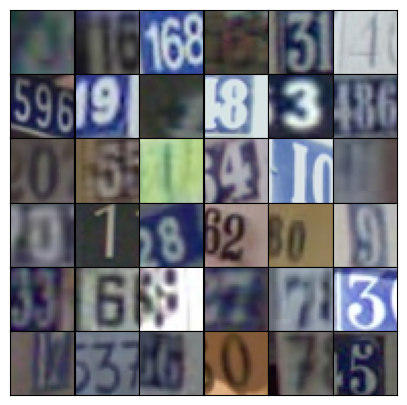

In [5]:
idx = np.random.randint(0, trainset['X'].shape[3], size=36)
fig, axes = plt.subplots(6, 6, sharex=True, sharey=True, figsize=(5, 5))
for i, ax in zip(idx, axes.flatten()):
  ax.imshow(trainset['X'][:, :, :, i], aspect='equal')
  ax.xaxis.set_visible(False)
  ax.yaxis.set_visible(False)
plt.subplots_adjust(wspace=0, hspace=0)

In [6]:
def scale(x, feature_range=(-1, 1)):
  x = (x - tf.reduce_min(x))/(255 - tf.reduce_min(x))

  min, max = feature_range
  x = x * (max - min) + min
  return x

In [ ]:
buffer_size = 70000
BATCH_SIZE = 256
train_dataset = tf.transpose(trainset['X'], (3, 0, 1, 2))
train_dataset = tf.data.Dataset.from_tensor_slices(train_dataset)
train_dataset = train_dataset.map(map_func=scale, num_parallel_calls=tf.data.AUTOTUNE).shuffle(buffer_size).batch(BATCH_SIZE)

In [ ]:
imgs = next(iter(train_dataset))
imgs.shape

In [ ]:
imgs[0]

In [ ]:
import random
index = random.randint(0, imgs.shape[0]-1)
plt.imshow(imgs[index])

In [ ]:
def build_generator_seq():
  model = tf.keras.Sequential()

  model.add(tf.keras.layers.Dense(4 * 4 * 512, input_shape=(100, ), use_bias=False))
  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.LeakyReLU())

  model.add(tf.keras.layers.Reshape((4, 4, 512)))

  print(model.output_shape)

  model.add(tf.keras.layers.Conv2DTranspose(256, (5, 5), strides=(2, 2), padding='same', use_bias=False))
  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.LeakyReLU())

  print(model.output_shape)

  model.add(tf.keras.layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.LeakyReLU())

  print(model.output_shape)

  model.add(tf.keras.layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding="same"))
  model.add(tf.keras.layers.Activation('tanh'))

  print(model.output_shape)

  return model

def build_generator_func():
  inputs = tf.keras.layers.Input(shape=(100,))
  x = tf.keras.layers.Dense(4*4*512)(inputs)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.LeakyReLU()(x)

  x = tf.keras.layers.Reshape((4, 4, 512))(x)

  x = tf.keras.layers.Conv2DTranspose(256, (5, 5), strides=(2, 2), padding='same', use_bias=True)(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.LeakyReLU()(x)

  x = tf.keras.layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same')(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.LeakyReLU()(x)



  outputs = tf.keras.layers.Conv2DTranspose(3, (5,5), strides=(2, 2), padding='same')(x)
  model = tf.keras.Model(inputs, outputs)
  print(model.output_shape)
  return model


In [ ]:
generator = build_generator_seq()
generator.summary()

In [ ]:
noise = tf.random.normal((1, 100))
img = generator(noise, training=False)
plt.imshow(tf.squeeze(img), cmap='gray')

In [ ]:
def build_discriminator():
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Conv2D(64, 5, strides=2, padding='same'))
  model.add(tf.keras.layers.LeakyReLU())

  model.add(tf.keras.layers.Conv2D(128, 5, strides=2, padding='same'))
  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.LeakyReLU())

  model.add(tf.keras.layers.Conv2D(256, 5, strides=2, padding='same'))
  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.LeakyReLU())

  model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dense(1))
  return model

In [ ]:
discriminator = build_discriminator()
decision = discriminator(img)
decision

In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
  real_loss = cross_entropy(tf.ones_like(real_output), real_output)
  fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)

  total_loss = real_loss + fake_loss
  return total_loss


def generator_loss(fake_output):
  return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [ ]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal((num_examples_to_generate, noise_dim))

In [ ]:
@tf.function
def train_step(images):
  noise = tf.random.normal((BATCH_SIZE, noise_dim))
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_imgs = generator(noise, training=True)

    real_output = discriminator(images, training=True)
    fake_output = discriminator(generated_imgs, training=True)

    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)

  gradient_gen = gen_tape.gradient(gen_loss, generator.trainable_variables)
  gradient_disc = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(gradient_gen, generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(gradient_disc, discriminator.trainable_variables))




In [ ]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)
  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      img = predictions[i]
      img = tf.cast(((img - tf.reduce_min(img)) * 255 / (tf.reduce_max(img) - tf.reduce_min(img))), dtype=tf.uint8)
      plt.imshow(img)
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [ ]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()
    for image_batch in dataset:
      train_step(image_batch)
      display.clear_output(wait=True)

      print(f'time for epoch {epoch + 1}, is {time.time() - start}')
      display.clear_output(wait=True)
      generate_and_save_images(generator, epochs, seed)

In [ ]:
train(train_dataset, EPOCHS)

(16, 32, 32, 3)
